### Using the DTD recovery test for RR Lyrae that Carles suggested

In [1]:
%pylab inline
import os
import string
import emcee
import corner
from scipy import misc
from matplotlib import pyplot as plt
import sys
import dtdutils

DTD_path = os.getenv('DTD')+'/'
sad_files_path = DTD_path + 'Output_SFH_Files/'

Populating the interactive namespace from numpy and matplotlib


In [7]:
def nCells_of_Survey(galaxyName, surveyName):
    nCells_dict = {'LMC':{'Boyer':1227, 'OGLE':808, 'Reid&Parker':723, '':1376}, \
                   'SMC':{'Boyer':378, '':428}}
    return nCells_dict[galaxyName][surveyName]

def nAgebins_scheme(binningScheme):
    bin_dict = {'Coarse':3, 'Massive':4, 'Medium':6, 'MediumB':6, 'MediumC':6, 'Subfine':7, 'Fine':8,\
               'CrazyCeph':8, 'Ultrafine':11, 'Unbinned': 16}
    return bin_dict[binningScheme]
#Define the likelihood function and the priors

def ln_like(psi, sfhMap, objMap, objMapFact, normApp, normIndexes, poissIndexes):
    l = np.dot(psi,sfhMap)
    if not normApp :
        return -1.0 * sum(l) + sum(np.log((l**objMap)/objMapFact)) 
    else :
        likeArr = np.zeros(nCells) 
        likeArr[normIndexes] = -0.5*np.log(2.0*np.pi*l) - ((objMap-l)**2.0)/(2.0*l)
        likeArr[poissIndexes] = -1.0 *l + np.log((l**objMap)/objMapFact)
        return sum(likeArr)    

def ln_prior(psi):
    if (psi < 0.0).any() : return -np.inf
    else : return 0.0

def ln_prob(psi, sfhMap, objMap, objMapFact, normApp, normIndexes, poissIndexes):
    lnprior = ln_prior(psi)
    if not np.isfinite(lnprior) : 
        return lnprior 
    return lnprior + ln_like(psi, sfhMap, objMap, objMapFact, normApp, normIndexes, poissIndexes)


### DTD Recovery Code

In [13]:
object_Name = 'RRLyrae'
object_Subtype = 'All'
binning_type = 'Unbinned'
#MCMC Parameters
nWalkers = 80
chainLength = 3000
nBurninSteps = 4000
print 'Number of walkers, chain length, burn-in length: ', nWalkers, chainLength, nBurninSteps
nIterations = 0
normThreshold = 25 #Threshold to use Normal instead of Poisson
afbThreshold = 0.01

sad_file_name = sad_files_path + 'LMC_SFH_Cells_' + object_Name + object_Subtype + '_' + binning_type + '.dat'

#Open file containing stellar masses for a given binning strategy, and only use the 
#rows with best-fit stellar masses. 
sad_file_obj = open(sad_file_name, 'r')
sad_file = sad_file_obj.readlines()
sad_file_obj.close()

sad_cellnames = np.array([lines.split()[0] for lines in sad_file if len(lines.split())==18])
sads = np.array([map(float, lines.split()[2:]) if len(lines.split())==18 else map(float, lines.split()) \
                 for lines in sad_file])

#Lots of things happening here. I'm reading each line of the file with the for statement, picking only lines that have
#best fit stellar mass (i.e. with 18 entries, 1st two being cell name and number of objects in cell). The split() splits
#up the full file string, and map(float,...) converts all the SAD entries into numbers!
dtd_old = np.concatenate(([0.]*14, [1.0e-5]*2))
    #Read SFHs and object count
objClassName = 'RRLyrae'
obj_subtype = 'All'
binningScheme = 'Unbinned'
refName = 'OGLE'
galaxy = 'LMC'
checkSFH = 'n'#raw_input('Save SFH comparisons? [y/n]: ')
subclassFolder = 'RRLyrae_linearSFH'
galaxy_pref = 'Fake_' #If, e.g., you're doing the fake maps. If not, then set galaxy_pref = ''

nCells = nCells_of_Survey(galaxy, refName)
nAgeBins = nAgebins_scheme(binningScheme)
sfhMap = sads[::3].T
sfhMapMin = sads[1::3].T
sfhMapMax = sads[2::3].T
ages, agebin_1, agebin_2 = dtdutils.sfh_ageBins(binning_type)

dtd_signal_array = []
dtd_mode_array = []
#plt.figure(figsize=(6,5))
nIterations = 100
for i in range(nIterations):
    print 'iteration ', i
    lambda_i = np.dot(sads[0::3], dtd_old)
    #print 100.*np.sum(lambda_i)/23459.  #Check if the fraction of old objects produced is consistent.
    objMap = np.random.poisson(lam=lambda_i)

    #Calculate array of factorials for use in likelihoods
    objMapFact = misc.factorial(objMap)
    if objMap.max() >= normThreshold :
        normApp = True 
        normIndexes = np.where(objMap >= normThreshold)
        poissIndexes = np.where(objMap < normThreshold)
     #   print 'Using Normal approximation for ', len(normIndexes[0]), ' cells'
    else :
        normApp = False
        normIndexes = np.array([])
        poissIndexes = np.arange(nCells)
    #    print 'Using Poisson statistics'

    #Choose an initial set of DTDs for the walkers; normal in log around -10, sigma = 3
    log10PsiMean0 = -5.0
    log10PsiSigma0 = 0.1
    log10Psi0 = [log10PsiSigma0*np.random.randn(nAgeBins)+log10PsiMean0 for i in xrange(nWalkers)]
    psi0 = np.power(10.0,log10Psi0)   

    #Initialize the sampler with the chosen specs.
#    print 'Initializing sampler'
    sampler = emcee.EnsembleSampler(nWalkers, nAgeBins, ln_prob, args=[sfhMap, objMap, objMapFact, normApp, normIndexes, poissIndexes])
    pos, prob, state = sampler.run_mcmc(psi0, nBurninSteps)         

    #Check that burn-in went well
    afb = np.mean(sampler.acceptance_fraction)
#    print 'Mean acceptance fraction during Burn-in:', afb
    if afb < afbThreshold :
        print 'Something went wrong'
        if step == nSteps-1 : sys.exit('End of loop.')
    #else :
        #continue
        #print 'Success!'

    # Reset the chain to remove the burn-in samples.
#    print 'Resetting chain'
    sampler.reset()

    # Starting from the final position in the burn-in chain, run sampler
#    print 'Starting run'
    #    stop
    sampler.run_mcmc(pos, chainLength, rstate0=state)

    # Print out the mean acceptance fraction.
#    print 'Mean acceptance fraction:', np.mean(sampler.acceptance_fraction)

    dtdchains = sampler.flatchain 

    dtd, dtd_error, isuplim = dtdutils.dtd_staterrors(dtdchains)
    dtd_no = np.array([signal if isuplim[i] else 0. for i, signal in enumerate(dtd)])
    dtd_yes = np.array([signal  if np.invert(isuplim[i]) else 0. for i,signal in enumerate(dtd)])
    dtd_signal_array.append(dtd_yes)
    #Appending all the DTD modes
    dtd_mode_array.append(np.array([dtdutils.dtd_mode(dtd_j) for dtd_j in dtdchains.T]))
    dtd_y = np.array([signal for i, signal in enumerate(dtd) if np.invert(isuplim[i])])
    ages_y = np.array([age for i, age in enumerate(ages) if np.invert(isuplim[i])])
#    dtd_yes_error = np.array([err for i, err in enumerate(dtd_error) if np.invert(isuplim[i])])
#    dtd_yes_error_low = dtd_yes_error[:,0]
#    dtd_yes_error_high = dtd_yes_error[:,1]
    
#    plt.errorbar(ages_y/1.0e6, dtd_y, yerr=(dtd_yes_error_low, dtd_yes_error_high), \
   #                  uplims=False, fmt='o', ls='', ecolor='k', label='')


Number of walkers, chain length, burn-in length:  80 3000 4000
iteration  0


/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
iteration  72
i

In [14]:
np.count_nonzero(dtd_signal_array, axis=0)/100.
np.savetxt('')

array([ 0.05,  0.06,  0.02,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,  0.02,
        0.  ,  0.02,  0.04,  0.  ,  0.08,  1.  ,  1.  ])

[array([  2.33583547e-05,   2.38017039e-06,   1.31248850e-06,
          2.50814066e-07,   6.75439835e-06,   2.56839266e-07,
          3.31740503e-06,   4.46211796e-08,   1.11617129e-07,
          1.21020543e-06,   1.82464830e-08,   5.01300024e-09,
          1.53728750e-08,   6.74703068e-07,   9.41320035e-06,
          9.00953741e-06]),
 array([  1.76109515e-06,   2.68140261e-06,   4.00572210e-07,
          2.62774267e-07,   1.61347406e-07,   9.29527611e-06,
          4.43881757e-07,   4.94298097e-07,   1.35101055e-07,
          5.71574152e-08,   1.76170581e-08,   6.27129131e-09,
          1.02484976e-08,   7.35432017e-08,   1.04912774e-05,
          8.93948009e-06]),
 array([  1.46246428e-06,   1.58187039e-06,   3.78534165e-06,
          2.11560617e-06,   1.00746261e-06,   2.37889419e-07,
          8.75467352e-08,   6.50840906e-08,   5.25829050e-08,
          3.94023455e-07,   2.04621849e-07,   8.29816830e-09,
          7.34539517e-07,   1.57371465e-07,   9.29557683e-06,
          9.09

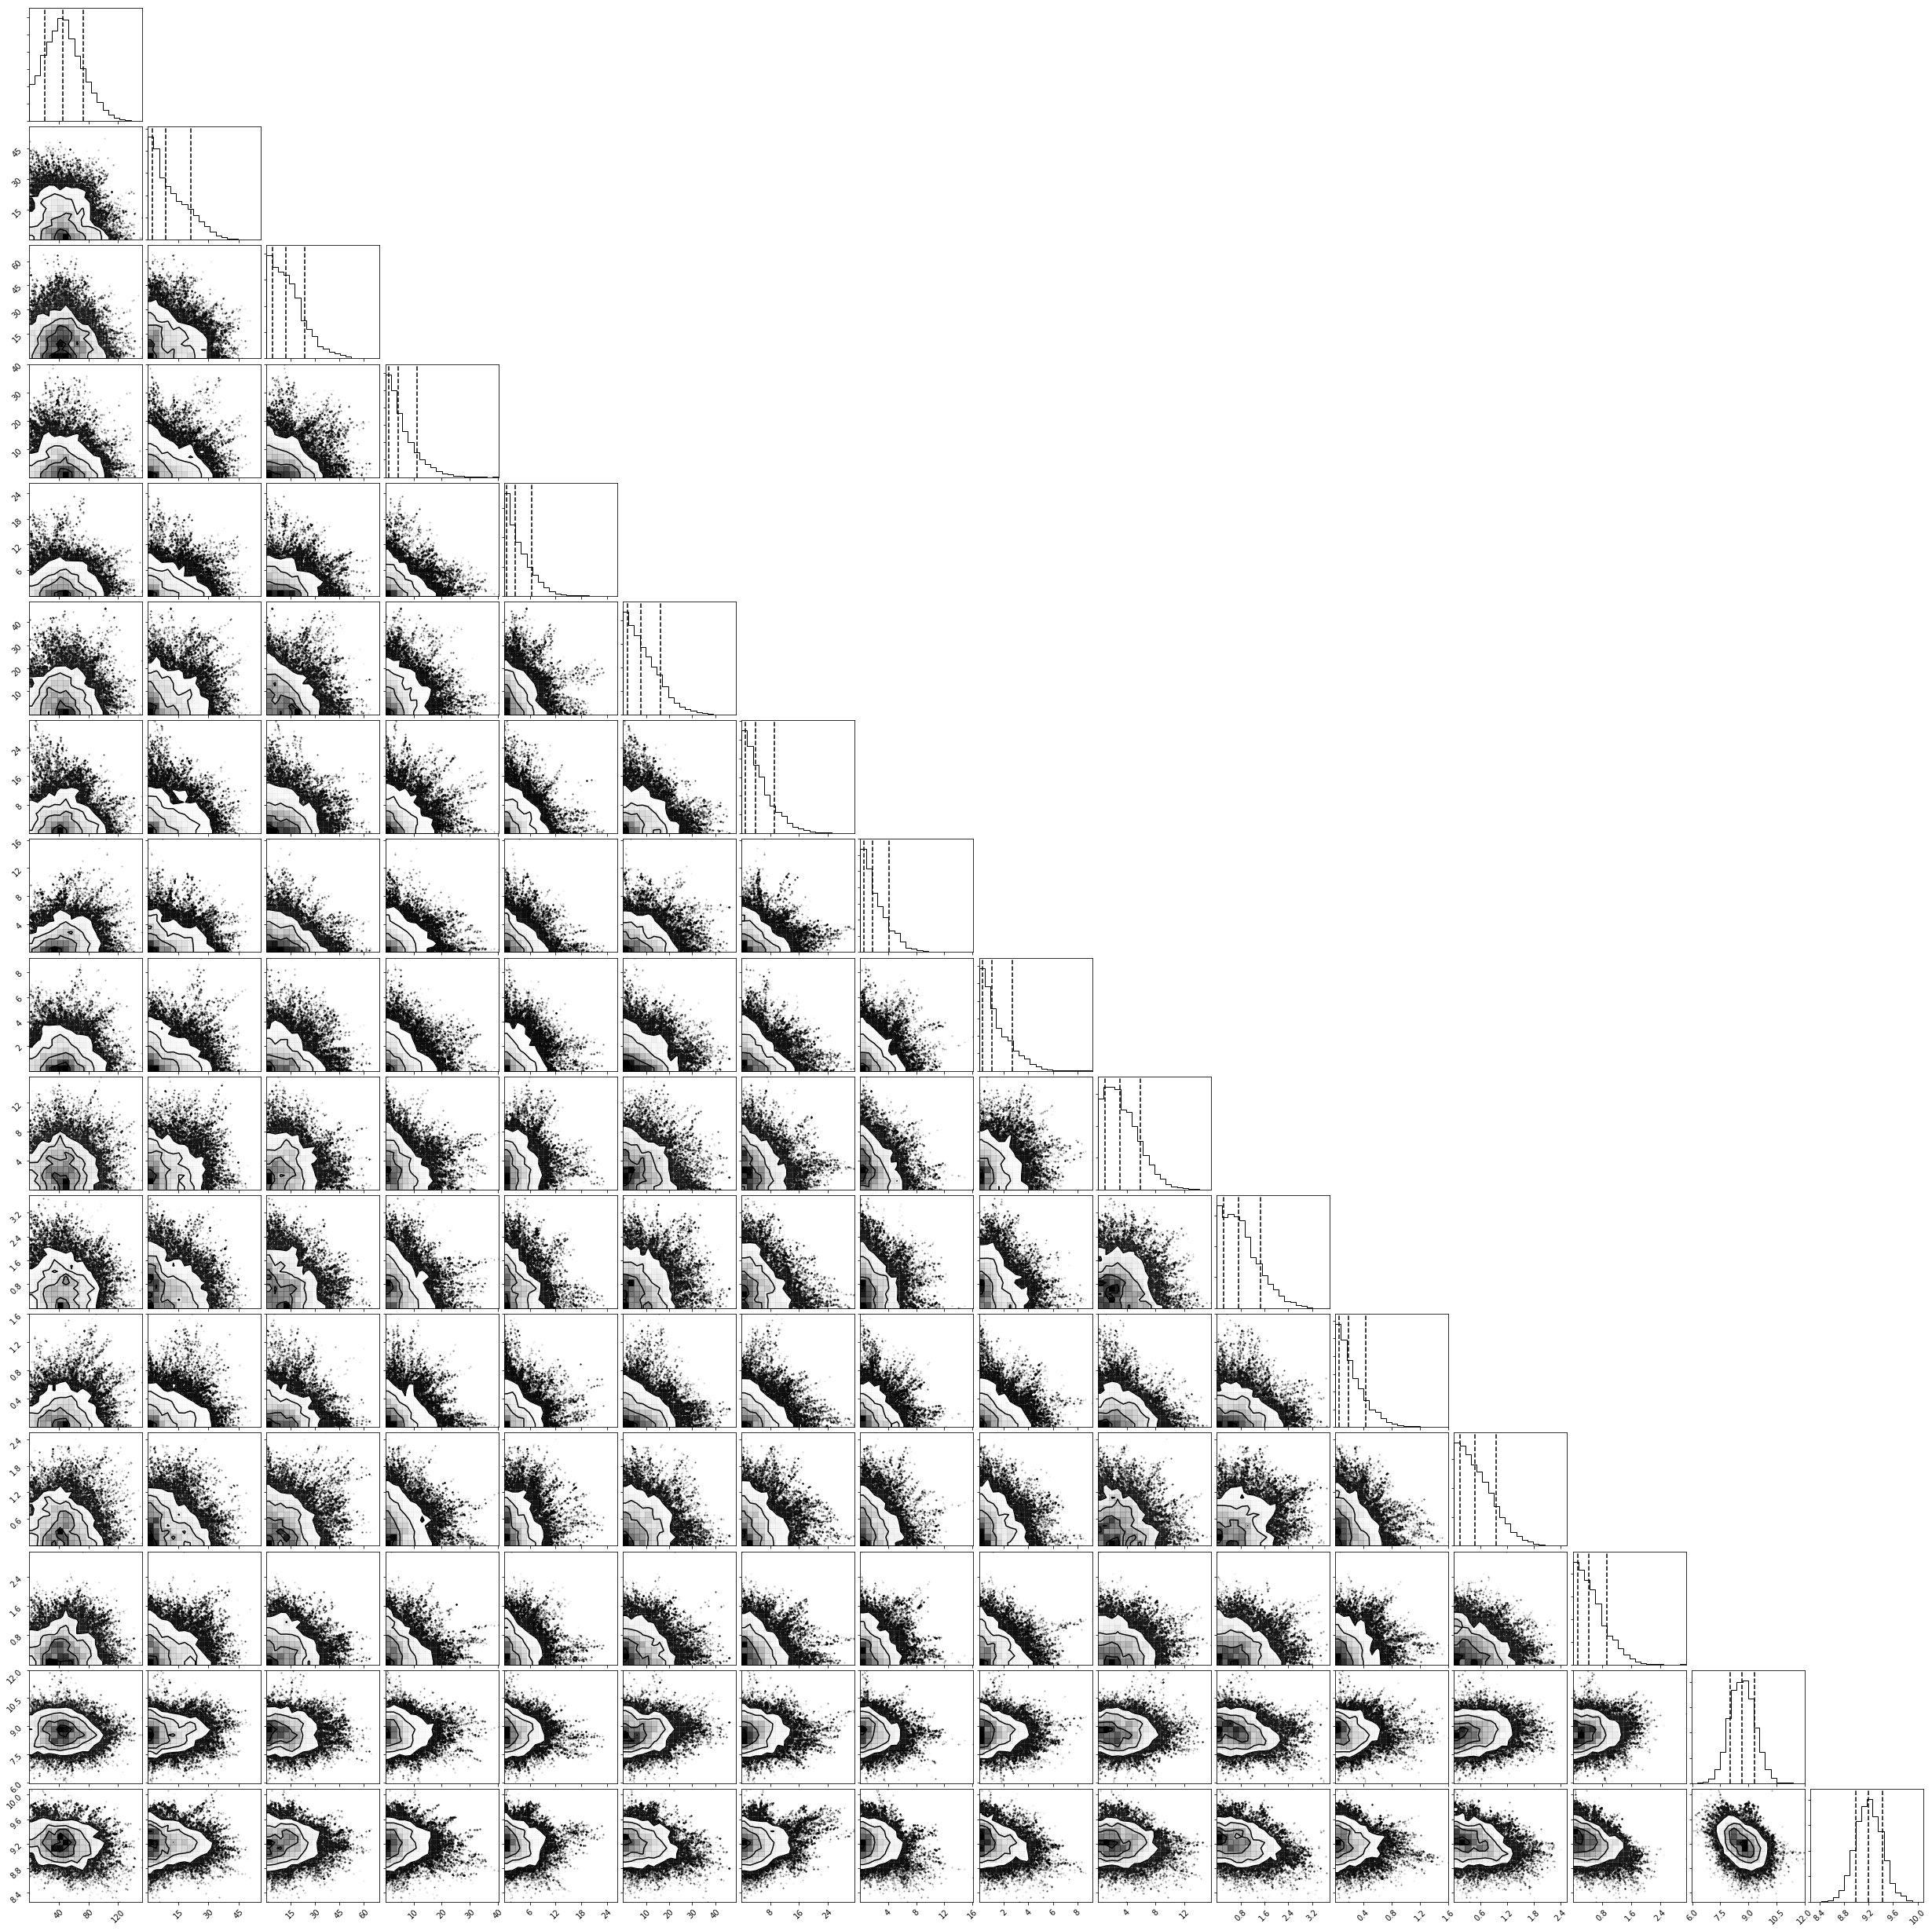

In [6]:
fig = corner.corner(dtdchains*1.0e6, quantiles=[0.16, 0.5, 0.84])